<a href="https://colab.research.google.com/github/edsonportosilva/OptiCommPy/blob/main/examples/test_fec.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
if 'google.colab' in str(get_ipython()):
    ! git clone -b main https://github.com/edsonportosilva/OptiCommPy
    from os import chdir as cd
    cd('/content/OptiCommPy/')
    ! pip install .

In [10]:
from optic.comm.modulation import modulateGray, demodulateGray, grayMapping
from optic.comm.metrics import calcLLR, fastBERcalc, monteCarloGMI
from optic.comm.fec import encodeLDPC, decodeLDPC, plotBinaryMatrix, summarizeAlistFolder
from optic.dsp.core import pnorm
from optic.models.channels import awgn
from optic.plot import pconst
from optic.utils import parameters
import matplotlib.pyplot as plt
import numpy as np
from tqdm import tqdm
from pathlib import Path
import time
from scipy.sparse import csr_matrix

In [3]:
%load_ext autoreload
%autoreload 2

## Simulate forward error correction (FEC) 

Basic simulation using LDPC encoding and decoding functions available in OptiCommPy. 

In [15]:
if 'google.colab' in str(get_ipython()):
    alistFolder = '/content/OptiCommPy/optic/comm/ALIST/'
else:
    # get the path of the current file and the repo path
    filePath = Path().resolve()
    repoPath = str(filePath.parent)
    alistFolder = repoPath + r'\optic\comm\ALIST\\' # change this to the path of the ALIST folder

print('Summary of ALIST files currently available in the repo:')
summarizeAlistFolder(alistFolder)

Summary of ALIST files currently available in the repo:
+-----------------------------------+------------+------------+-------+-------------+---------------+
|                File               | n (length) | m (checks) |  Rate | Max Var Deg | Max Check Deg |
+-----------------------------------+------------+------------+-------+-------------+---------------+
|      LDPC_AR4JA_1280b_R45.txt     |    1408    |    384     | 0.727 |     1408    |       18      |
|      LDPC_AR4JA_1536b_R23.txt     |    1792    |    768     | 0.571 |     1792    |       10      |
|     LDPC_AR4JA_18720b_R78.txt     |   22528    |    6144    | 0.727 |    22528    |       18      |
|     LDPC_AR4JA_20160b_R45.txt     |   22528    |    6144    | 0.727 |    22528    |       18      |
|     LDPC_AR4JA_20480b_R45.txt     |   22528    |    6144    | 0.727 |    22528    |       18      |
|      LDPC_AR4JA_2048b_R12.txt     |    2560    |    1536    | 0.400 |     2560    |       6       |
|     LDPC_AR4JA_21840b_R3

## Test LDPC encoder/decoder

Time for encoding per codeword: 968.64 ms


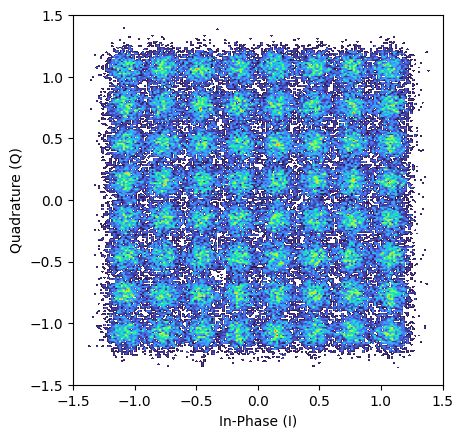

Time for decoding - total: 10.44 s, per codeword: 1739.87 ms

----------------------Results-------------------------

LDPC DVBS2: k = 51840, n = 64800
Net rate = 4.80 bits/symbol
GMI = 5.62 bits/symbol
BERpreFEC = 1.69e-02
BERpostFEC = 0.00e+00
Total number of bits =  388800


In [16]:
# run AWGN simulation
EbN0dB = 11   # SNR per bit in dB
M      = 64   # modulation order
Nwords = 6    # number of codewords
nIter  = 50   # maximum number of decoding iterations

# modulation parameters
constSymb = grayMapping(M,'qam')             # constellation
bitMap = demodulateGray(constSymb, M, 'qam') # bit mapping
bitMap = bitMap.reshape(-1, int(np.log2(M)))

# encode data bits with LDPC
paramEnc = parameters()
paramEnc.mode = 'DVBS2' #'IEEE_802.11nD2', 'DVBS2'
paramEnc.n = 64800
paramEnc.R = '4/5'
paramEnc.path = alistFolder

k = (paramEnc.n*int(paramEnc.R[0]))//int(paramEnc.R[2])

# generate random bits
bits = np.random.randint(2, size = (k, Nwords), dtype=np.uint8)

# encode bits with LDPC code
start = time.time()
codedBits = encodeLDPC(bits, paramEnc)
end = time.time()
print(f'Time for encoding per codeword: {(end-start)/Nwords*1000:.2f} ms')

codedBitsTx = codedBits.copy().flatten()

# map coded bits to constellation symbols
symbTx = modulateGray(codedBitsTx, M, 'qam')

# normalize symbols energy to 1
symbTx = pnorm(symbTx)

# AWGN channel
snrdB  = EbN0dB + 10*np.log10(np.log2(M))
symbRx = awgn(symbTx, snrdB)

# pre-FEC BER calculation (hard demodulation)
BERpre, _, _ = fastBERcalc(symbRx, symbTx, M, 'qam')
GMI, NGMI = monteCarloGMI(symbRx, symbTx, M, 'qam')

pconst(symbRx, pType='fancy', R=1.5)

# soft-demodulation
noiseVar = 1/10**(snrdB/10)
px = np.ones(M)/M
llrs = calcLLR(pnorm(symbRx), noiseVar, pnorm(constSymb), bitMap, px)
llrs = llrs.reshape(-1, Nwords) # reshape to (n, Nwords)

# soft-decoding
paramDec = parameters()
paramDec.H = paramEnc.H
paramDec.alg = 'MSA'
paramDec.maxIter = nIter
paramDec.prgsBar = True
paramDec.prec = np.float32

start = time.time()
decodedBits, llr_dec, frameErrors = decodeLDPC(llrs, paramDec)
end = time.time()
print(f'Time for decoding - total: {end-start:.2f} s, per codeword: {(end-start)/Nwords*1000:.2f} ms\n')


# post-FEC BER calculation
BERpost = np.mean(np.logical_xor(codedBitsTx.flatten(), decodedBits.flatten()))
print('----------------------Results-------------------------\n')
print(f'LDPC {paramEnc.mode}: k = {k}, n = {int(paramEnc.n)}')
print(f'Net rate = {int(paramEnc.R[0])/int(paramEnc.R[2])*np.log2(M):.2f} bits/symbol')
print(f'GMI = {GMI[0]:.2f} bits/symbol')
print(f'BERpreFEC = {BERpre[0]:.2e}')
print(f'BERpostFEC = {BERpost:.2e}')
print(f'Total number of bits = ', decodedBits.size)

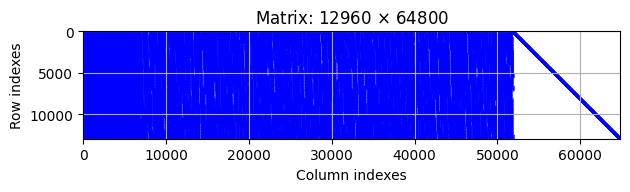

In [17]:
plotBinaryMatrix(csr_matrix.todense(paramEnc.H))

## Evaluate performance as a function of the received SNR

In [6]:
Nwords = 20  # number of codewords
M = 64 # modulation order

# Run BER vs Ebn0 Monte Carlo simulation
nIter_  = [10, 20, 50, 100, 200]  # max decoding iterations
EbN0dB_  = np.arange(8.2, 9.1, 0.1)

BERpre_mc   = np.zeros((len(EbN0dB_),len(nIter_)))
BERpost_mc  = np.zeros((len(EbN0dB_),len(nIter_)))

BERpre_mc[:]  = np.nan
BERpost_mc[:] = np.nan

for ii, nIter in enumerate(nIter_):
    print('run sim: M = ', M)

    # modulation parameters
    constSymb = grayMapping(M,'qam')             # constellation
    bitMap = demodulateGray(constSymb, M, 'qam') # bit mapping
    bitMap = bitMap.reshape(-1, int(np.log2(M)))

    for indSNR in tqdm(range(EbN0dB_.size)):

        EbN0dB = EbN0dB_[indSNR]

        # encode data bits with LDPC
        paramEnc = parameters()
        paramEnc.mode = 'DVBS2' #'IEEE_802.11nD2'
        paramEnc.n = 64800
        paramEnc.R = '4/5'
        paramEnc.path = alistFolder

        k = (paramEnc.n*int(paramEnc.R[0]))//int(paramEnc.R[2])

        # generate random bits
        bits = np.random.randint(2, size = (k, Nwords), dtype=np.uint8)

        # encode bits with LDPC code
        start = time.time()
        codedBits = encodeLDPC(bits, paramEnc)
        end = time.time()
        #print(f'Time for encoding per codeword: {(end-start)/Nwords*1000:.2f} ms')

        codedBitsTx = codedBits.copy().flatten()

        # map coded bits to constellation symbols
        symbTx = modulateGray(codedBitsTx, M, 'qam')

        # normalize symbols energy to 1
        symbTx = pnorm(symbTx)

        # AWGN  channel
        snrdB = EbN0dB + 10*np.log10(np.log2(M))
        symbRx = awgn(symbTx, snrdB)

        # pre-FEC BER calculation (hard demodulation)
        BERhd, _, _ = fastBERcalc(symbRx, symbTx, M, 'qam')
        BERpre_mc[indSNR, ii] = BERhd[0]

        # soft-demodulation
        noiseVar = 1/10**(snrdB/10)
        px = np.ones(M)/M
        llr = calcLLR(pnorm(symbRx), noiseVar, pnorm(constSymb), bitMap, px)
        llr = llr.reshape(-1, Nwords)
        
        # soft-decoding
        paramDec = parameters()
        paramDec.H = paramEnc.H
        paramDec.alg = 'MSA'
        paramDec.maxIter = nIter
        paramDec.prgsBar = False
        paramDec.prec = np.float32

        start = time.time()
        decodedBits, llr_dec, _ = decodeLDPC(llr, paramDec)
        end = time.time()
        #print(f'Time for decoding per codeword: {(end-start)/Nwords*1000:.2f} ms')
        

        # post-FEC BER calculation
        BERpost_mc[indSNR, ii] = np.mean(np.logical_xor(codedBitsTx.flatten(), decodedBits.flatten()))

run sim: M =  64


100%|██████████| 10/10 [03:27<00:00, 20.74s/it]


run sim: M =  64


100%|██████████| 10/10 [05:02<00:00, 30.22s/it]


run sim: M =  64


100%|██████████| 10/10 [07:37<00:00, 45.75s/it]


run sim: M =  64


100%|██████████| 10/10 [12:04<00:00, 72.50s/it]


run sim: M =  64


100%|██████████| 10/10 [17:47<00:00, 106.78s/it]


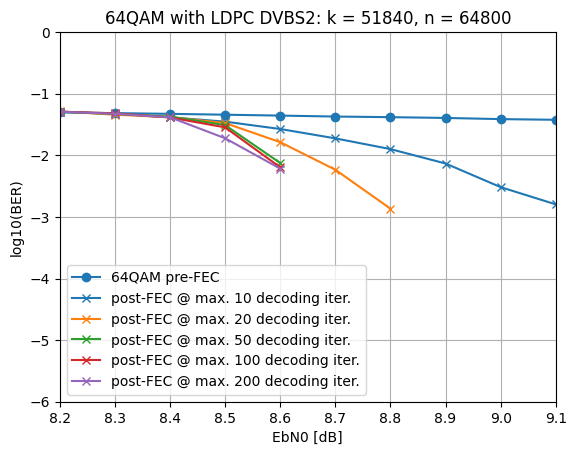

In [7]:
# Plot simulation results
BERpre_mc[BERpre_mc==0] = np.nan
BERpost_mc[BERpost_mc==0] = np.nan

#plt.figure(figsize=(10,6))
#for ii, nIter in enumerate(nIter_[0]):
plt.plot(EbN0dB_,np.log10(BERpre_mc[:, 0]),'o-',label=f'{str(M)}QAM pre-FEC')
plt.gca().set_prop_cycle(None)
plt.title(f'{str(M)}QAM with LDPC {paramEnc.mode}: k = {k}, n = {int(paramEnc.n)}')

for ii, nIter in enumerate(nIter_):
    plt.plot(EbN0dB_, np.log10(BERpost_mc[:, ii]),'x-', label=f'post-FEC @ max. {nIter} decoding iter.')

plt.xlim(min(EbN0dB_), max(EbN0dB_))
plt.ylim(-6, 0)
plt.legend();
plt.xlabel('EbN0 [dB]')
plt.ylabel('log10(BER)')
plt.grid();